In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from itertools import combinations, permutations

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader

from helpers.data_generation.file_management import read_hdf5
from helpers.data_generation.error_generation import Residual, CombineDataset
from helpers.model.helpers_model import NeuralNet

import warnings
warnings.filterwarnings('ignore') 

from sklearn.metrics import precision_recall_curve, f1_score, auc, accuracy_score, roc_curve, roc_auc_score

In [13]:
# Build the four classes 
ratio = 0.75

size = 500
i_percent = np.linspace(0.005, 0.15, 3)

comb_percent = list(combinations(i_percent, 2))
comb_percent = [comb_percent[ii] + (comb_percent[ii][0],) for ii in range(len(comb_percent))]

In [14]:
auc_mass = []; auc_source = [];
percent_mass = []; percent_source = [];
k = 0
for percent_i in comb_percent:
    percent = np.asarray(percent_i)
    res = Residual()
    k+=1
    res.build(size, ratio = ratio, per_error = percent)
    str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
    [final_array, metadata] = read_hdf5(str_ID)
    metadata ['ID'] = np.arange(0,final_array.shape[0])
    data_set = CombineDataset(metadata,'ID','class',final_array)

    data_train, data_test = train_test_split(data_set,train_size=0.9,random_state=42)

    batch_size = 50
    max_epoch = 40
    loader_train = DataLoader(data_train, batch_size = batch_size, 
                            num_workers = 0, drop_last=True)

    loader_test = DataLoader(data_test, batch_size = batch_size, 
                            num_workers = 0, drop_last=True)
    
    netacc = NeuralNet('BasicCNN', 'Adam')
    for epoch in range(max_epoch):
        netacc.train(loader_train)
        res = netacc.test(loader_test, verbose = False)

        
    if k%10 == 0 :
        print('Finished Training : ' + str(k)+'/'+str(len(comb_percent)))
    epoch = netacc.load_checkpoint()

    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta, labels = data
            outputs = netacc.net(images)

            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            result = netacc.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        predictions = np.round(np.array(predictions)); targets = np.array(targets)
        curr_mass = roc_auc_score(targets[:,0], predictions[:,0], average = 'samples') 
        curr_source = roc_auc_score(targets[:,1], predictions[:,1], average = 'samples') 
        
        auc_mass.append(curr_mass)
        auc_source.append(curr_source)
        percent_mass.append(percent[0])
        percent_source.append(percent[1])
        


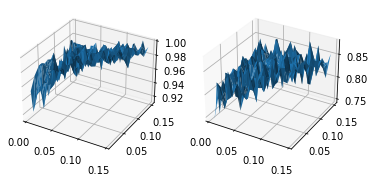

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1,projection='3d')
ax.plot_trisurf(percent_mass, percent_source, auc_mass, label= 'mass')
ax = fig.add_subplot(1, 2, 2,projection='3d')
ax.plot_trisurf(percent_mass, percent_source, auc_source, label= 'source')
plt.savefig('figures/percent_baseline.jpeg')
plt.show()

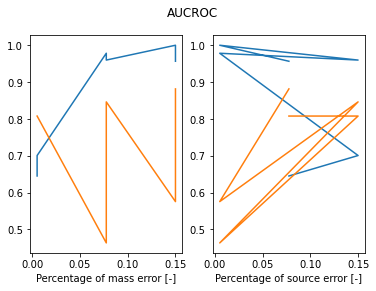

In [15]:
fig, axs = plt.subplots(1,2)
fig.suptitle('AUCROC')
axs[0].plot(percent_mass, auc_mass, label = 'Mass')
axs[0].plot(percent_mass, auc_source, label = 'Source')
axs[1].plot(percent_source, auc_mass)
axs[1].plot(percent_source, auc_source)
axs[0].set_xlabel('Percentage of mass error [-]')
axs[1].set_xlabel('Percentage of source error [-]')
plt.savefig('figures/percent_baseline.jpeg')
plt.show()